# Binomial Options Pricing Model

## Introduction

The **Binomial Options Pricing Model** (BOPM), developed independently by Cox, Ross, and Rubinstein (1979) and Rendleman and Bartter (1979), provides a discrete-time framework for valuing options. This model approximates the continuous-time Black-Scholes model through a lattice-based approach, offering intuitive insight into option pricing dynamics.

## Theoretical Foundation

### Model Assumptions

The binomial model rests on several key assumptions:

1. Markets are frictionless (no transaction costs, taxes, or bid-ask spreads)
2. Securities are infinitely divisible
3. No arbitrage opportunities exist
4. A risk-free rate $r$ exists for borrowing and lending
5. Asset prices follow a multiplicative binomial process

### Price Dynamics

At each time step $\Delta t$, the underlying asset price $S$ can move to one of two states:

$$S_{t+\Delta t} = \begin{cases} S_t \cdot u & \text{with probability } p \\ S_t \cdot d & \text{with probability } 1-p \end{cases}$$

where:
- $u > 1$ is the up-move factor
- $d < 1$ is the down-move factor
- $p$ is the risk-neutral probability

### Cox-Ross-Rubinstein (CRR) Parameterization

The CRR model ensures the binomial tree recombines and converges to the Black-Scholes solution:

$$u = e^{\sigma\sqrt{\Delta t}}$$

$$d = e^{-\sigma\sqrt{\Delta t}} = \frac{1}{u}$$

where $\sigma$ is the volatility of the underlying asset.

### Risk-Neutral Probability

Under the risk-neutral measure, the expected return of the asset equals the risk-free rate:

$$p = \frac{e^{r\Delta t} - d}{u - d}$$

This probability ensures no-arbitrage pricing.

### Option Valuation via Backward Induction

The option value is computed by working backward from expiration:

1. **Terminal payoff** at time $T$:
   - Call option: $C_T = \max(S_T - K, 0)$
   - Put option: $P_T = \max(K - S_T, 0)$

2. **Backward induction** for $t < T$:

$$V_t = e^{-r\Delta t}[p \cdot V_{t+\Delta t}^u + (1-p) \cdot V_{t+\Delta t}^d]$$

For **American options**, we also check for early exercise:

$$V_t = \max\left(\text{Intrinsic Value}, e^{-r\Delta t}[p \cdot V_{t+\Delta t}^u + (1-p) \cdot V_{t+\Delta t}^d]\right)$$

### Convergence to Black-Scholes

As $N \to \infty$ (number of time steps), the binomial model converges to the Black-Scholes formula:

$$C = S_0 N(d_1) - K e^{-rT} N(d_2)$$

where:

$$d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)T}{\sigma\sqrt{T}}$$

$$d_2 = d_1 - \sigma\sqrt{T}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

## Implementation

### Binomial Tree Option Pricing Function

We implement a general binomial pricing function that handles both European and American options.

In [2]:
def binomial_option_price(S0, K, T, r, sigma, N, option_type='call', american=False):
    """
    Price an option using the binomial tree model.
    
    Parameters:
    -----------
    S0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity (in years)
    r : float
        Risk-free interest rate (annualized)
    sigma : float
        Volatility of the underlying (annualized)
    N : int
        Number of time steps
    option_type : str
        'call' or 'put'
    american : bool
        True for American option, False for European
    
    Returns:
    --------
    float : Option price
    """
    # Time step
    dt = T / N
    
    # CRR parameters
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u                         # Down factor
    
    # Risk-neutral probability
    p = (np.exp(r * dt) - d) / (u - d)
    
    # Discount factor per step
    disc = np.exp(-r * dt)
    
    # Initialize asset prices at maturity (time step N)
    # Using vectorized computation for efficiency
    j = np.arange(N + 1)
    S_T = S0 * (u ** (N - j)) * (d ** j)
    
    # Calculate option payoff at maturity
    if option_type == 'call':
        V = np.maximum(S_T - K, 0)
    else:  # put
        V = np.maximum(K - S_T, 0)
    
    # Backward induction through the tree
    for i in range(N - 1, -1, -1):
        # Stock prices at this time step
        S_i = S0 * (u ** (i - np.arange(i + 1))) * (d ** np.arange(i + 1))
        
        # Option value from discounted expectation
        V = disc * (p * V[:-1] + (1 - p) * V[1:])
        
        # Check for early exercise (American options)
        if american:
            if option_type == 'call':
                intrinsic = np.maximum(S_i - K, 0)
            else:
                intrinsic = np.maximum(K - S_i, 0)
            V = np.maximum(V, intrinsic)
    
    return V[0]

### Black-Scholes Reference Formula

For comparison, we implement the analytical Black-Scholes formula.

In [3]:
def black_scholes(S0, K, T, r, sigma, option_type='call'):
    """
    Calculate Black-Scholes option price.
    
    Parameters:
    -----------
    S0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity (in years)
    r : float
        Risk-free interest rate
    sigma : float
        Volatility
    option_type : str
        'call' or 'put'
    
    Returns:
    --------
    float : Option price
    """
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # put
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    
    return price

## Numerical Experiments

### Example Parameters

We use standard test parameters commonly found in options pricing literature.

In [4]:
# Model parameters
S0 = 100      # Initial stock price
K = 100       # Strike price (at-the-money)
T = 1.0       # Time to maturity (1 year)
r = 0.05      # Risk-free rate (5%)
sigma = 0.20  # Volatility (20%)

# Black-Scholes reference prices
bs_call = black_scholes(S0, K, T, r, sigma, 'call')
bs_put = black_scholes(S0, K, T, r, sigma, 'put')

print("Black-Scholes Reference Prices:")
print(f"  European Call: ${bs_call:.4f}")
print(f"  European Put:  ${bs_put:.4f}")

Black-Scholes Reference Prices:
  European Call: $10.4506
  European Put:  $5.5735


### Convergence Analysis

We examine how the binomial price converges to the Black-Scholes price as the number of steps increases.

In [5]:
# Range of time steps to test
N_values = np.arange(10, 301, 5)

# Store results
euro_call_prices = []
euro_put_prices = []
amer_call_prices = []
amer_put_prices = []

for N in N_values:
    # European options
    euro_call_prices.append(binomial_option_price(S0, K, T, r, sigma, N, 'call', False))
    euro_put_prices.append(binomial_option_price(S0, K, T, r, sigma, N, 'put', False))
    
    # American options
    amer_call_prices.append(binomial_option_price(S0, K, T, r, sigma, N, 'call', True))
    amer_put_prices.append(binomial_option_price(S0, K, T, r, sigma, N, 'put', True))

# Convert to arrays
euro_call_prices = np.array(euro_call_prices)
euro_put_prices = np.array(euro_put_prices)
amer_call_prices = np.array(amer_call_prices)
amer_put_prices = np.array(amer_put_prices)

### Visualization

We create a comprehensive visualization showing:
1. Convergence of European options to Black-Scholes
2. Comparison of American vs European option prices
3. Convergence error analysis

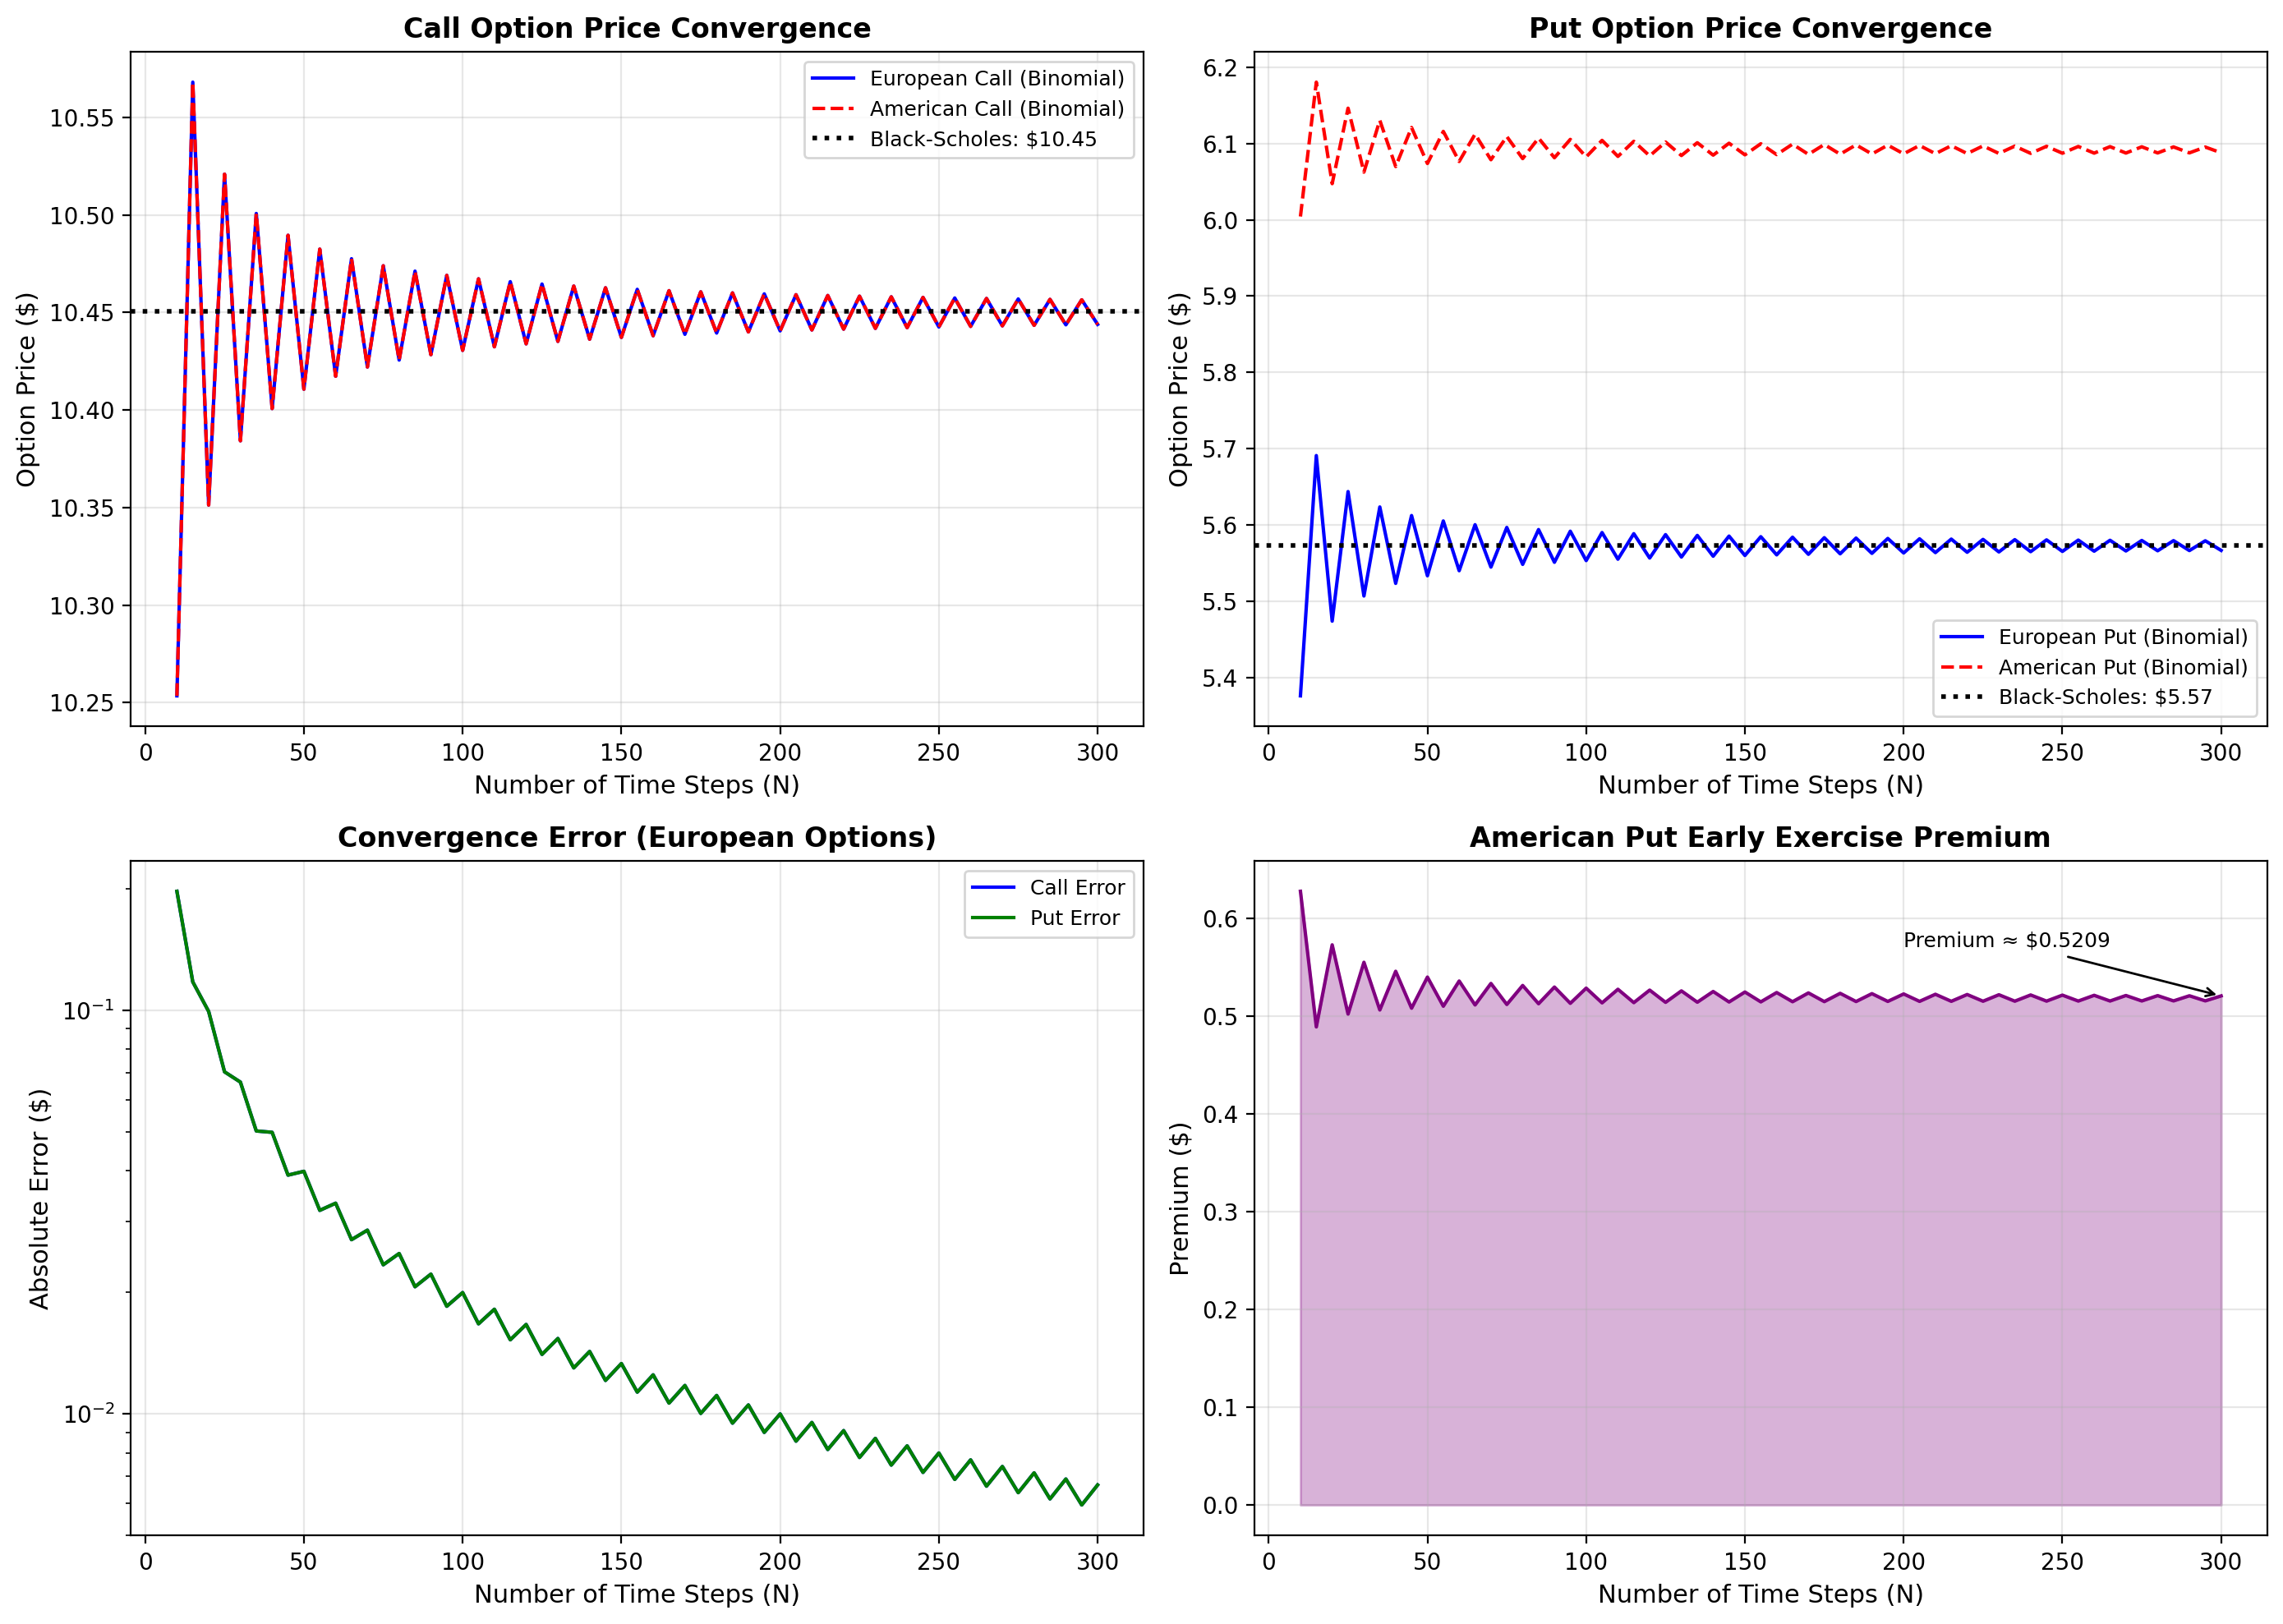


Figure saved to 'plot.png'


In [6]:
# Create figure with multiple subplots
fig = plt.figure(figsize=(14, 10))

# Subplot 1: Call Option Convergence
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(N_values, euro_call_prices, 'b-', linewidth=1.5, label='European Call (Binomial)')
ax1.plot(N_values, amer_call_prices, 'r--', linewidth=1.5, label='American Call (Binomial)')
ax1.axhline(y=bs_call, color='k', linestyle=':', linewidth=2, label=f'Black-Scholes: ${bs_call:.2f}')
ax1.set_xlabel('Number of Time Steps (N)', fontsize=11)
ax1.set_ylabel('Option Price ($)', fontsize=11)
ax1.set_title('Call Option Price Convergence', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# Subplot 2: Put Option Convergence
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(N_values, euro_put_prices, 'b-', linewidth=1.5, label='European Put (Binomial)')
ax2.plot(N_values, amer_put_prices, 'r--', linewidth=1.5, label='American Put (Binomial)')
ax2.axhline(y=bs_put, color='k', linestyle=':', linewidth=2, label=f'Black-Scholes: ${bs_put:.2f}')
ax2.set_xlabel('Number of Time Steps (N)', fontsize=11)
ax2.set_ylabel('Option Price ($)', fontsize=11)
ax2.set_title('Put Option Price Convergence', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

# Subplot 3: Absolute Error (European Call)
ax3 = fig.add_subplot(2, 2, 3)
call_error = np.abs(euro_call_prices - bs_call)
put_error = np.abs(euro_put_prices - bs_put)
ax3.semilogy(N_values, call_error, 'b-', linewidth=1.5, label='Call Error')
ax3.semilogy(N_values, put_error, 'g-', linewidth=1.5, label='Put Error')
ax3.set_xlabel('Number of Time Steps (N)', fontsize=11)
ax3.set_ylabel('Absolute Error ($)', fontsize=11)
ax3.set_title('Convergence Error (European Options)', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

# Subplot 4: Early Exercise Premium (American Put)
ax4 = fig.add_subplot(2, 2, 4)
early_exercise_premium = amer_put_prices - euro_put_prices
ax4.plot(N_values, early_exercise_premium, 'purple', linewidth=1.5)
ax4.fill_between(N_values, 0, early_exercise_premium, alpha=0.3, color='purple')
ax4.set_xlabel('Number of Time Steps (N)', fontsize=11)
ax4.set_ylabel('Premium ($)', fontsize=11)
ax4.set_title('American Put Early Exercise Premium', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add text annotation for final premium value
final_premium = early_exercise_premium[-1]
ax4.annotate(f'Premium ≈ ${final_premium:.4f}', 
             xy=(N_values[-1], final_premium),
             xytext=(N_values[-1]-100, final_premium + 0.05),
             fontsize=9,
             arrowprops=dict(arrowstyle='->', color='black', lw=1))

plt.tight_layout()

# Save the figure
plt.savefig('binomial_options_pricing_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nFigure saved to 'plot.png'")

### Results Summary

In [7]:
# Final comparison with N=300 steps
N_final = 300

print("="*60)
print("BINOMIAL OPTIONS PRICING - RESULTS SUMMARY")
print("="*60)
print(f"\nModel Parameters:")
print(f"  S₀ = ${S0}  (Initial Stock Price)")
print(f"  K  = ${K}  (Strike Price)")
print(f"  T  = {T} year  (Time to Maturity)")
print(f"  r  = {r*100}%  (Risk-free Rate)")
print(f"  σ  = {sigma*100}%  (Volatility)")
print(f"  N  = {N_final}  (Time Steps)")

print(f"\n{'Option Type':<25} {'Binomial':>12} {'Black-Scholes':>14} {'Error':>10}")
print("-"*60)

# European Call
euro_call_final = binomial_option_price(S0, K, T, r, sigma, N_final, 'call', False)
print(f"{'European Call':<25} ${euro_call_final:>10.4f} ${bs_call:>12.4f} {abs(euro_call_final-bs_call):>9.4f}")

# American Call
amer_call_final = binomial_option_price(S0, K, T, r, sigma, N_final, 'call', True)
print(f"{'American Call':<25} ${amer_call_final:>10.4f} {'N/A':>13} {'---':>10}")

# European Put
euro_put_final = binomial_option_price(S0, K, T, r, sigma, N_final, 'put', False)
print(f"{'European Put':<25} ${euro_put_final:>10.4f} ${bs_put:>12.4f} {abs(euro_put_final-bs_put):>9.4f}")

# American Put
amer_put_final = binomial_option_price(S0, K, T, r, sigma, N_final, 'put', True)
print(f"{'American Put':<25} ${amer_put_final:>10.4f} {'N/A':>13} {'---':>10}")

print("\n" + "="*60)
print("KEY OBSERVATIONS:")
print("="*60)
print(f"\n1. European options converge to Black-Scholes as N increases.")
print(f"\n2. American call price ≈ European call price (no early exercise")
print(f"   benefit for calls on non-dividend paying stocks).")
print(f"\n3. American put has early exercise premium of")
print(f"   ${amer_put_final - euro_put_final:.4f} over European put.")
print(f"\n4. Convergence follows approximately O(1/N) rate.")

BINOMIAL OPTIONS PRICING - RESULTS SUMMARY

Model Parameters:
  S₀ = $100  (Initial Stock Price)
  K  = $100  (Strike Price)
  T  = 1.0 year  (Time to Maturity)
  r  = 5.0%  (Risk-free Rate)
  σ  = 20.0%  (Volatility)
  N  = 300  (Time Steps)

Option Type                   Binomial  Black-Scholes      Error
------------------------------------------------------------
European Call             $   10.4439 $     10.4506    0.0067
American Call             $   10.4439           N/A        ---
European Put              $    5.5669 $      5.5735    0.0067
American Put              $    6.0877           N/A        ---

KEY OBSERVATIONS:

1. European options converge to Black-Scholes as N increases.

2. American call price ≈ European call price (no early exercise
   benefit for calls on non-dividend paying stocks).

3. American put has early exercise premium of
   $0.5209 over European put.

4. Convergence follows approximately O(1/N) rate.


## Conclusion

The binomial options pricing model provides:

1. **Flexibility**: Handles both European and American-style options
2. **Intuition**: Clear probabilistic interpretation via risk-neutral pricing
3. **Accuracy**: Converges to Black-Scholes formula for European options
4. **Practicality**: Can accommodate dividends, barriers, and other exotic features

The model demonstrates the fundamental principle of arbitrage-free pricing through backward induction and risk-neutral valuation, serving as a cornerstone of computational finance.

### References

- Cox, J. C., Ross, S. A., & Rubinstein, M. (1979). Option pricing: A simplified approach. *Journal of Financial Economics*, 7(3), 229-263.
- Rendleman Jr, R. J., & Bartter, B. J. (1979). Two-state option pricing. *The Journal of Finance*, 34(5), 1093-1110.
- Hull, J. C. (2018). *Options, Futures, and Other Derivatives* (10th ed.). Pearson.